In [96]:
import os, sys

PATH_DATA = os.path.dirname(os.path.dirname(os.getcwd()))
PATH_DATA

'/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index'

In [97]:
import pandas as pd
import numpy as np
import shapefile as shp
import osmnx as ox
import contextily as ctx
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D  # for legend handle
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics.pairwise import haversine_distances
from shapely.geometry import Point
from pyproj import Proj, transform
import math
from matplotlib.colors import Normalize

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "../src"))
import functions_support as fsupport

import importlib

importlib.reload(fsupport)

<module 'functions_support' from '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/notebooks/../src/functions_support.py'>

## Global variables


In [98]:
COUNTRY_NAME = "peru"
RESULT_DIR = "results_INEI"

In [99]:
directory = PATH_DATA + "/data/" + COUNTRY_NAME + "/" + RESULT_DIR
if not os.path.exists(directory):
    os.makedirs(directory)

## Administrative areas


In [100]:
path = (
    PATH_DATA + "/data/" + COUNTRY_NAME + "/preprocessed_sources/administrative_region"
)
files = os.listdir(path)

administrative_areas_dict = dict()

for i in files:
    name = fsupport.capitalize_string(i[:-8])
    # adminitration = fsupport.capitalize_string(i[-9:-8])
    # # key_tag = f'{name} {fsupport.category_dict[adminitration]}'
    # key_tag = f'{name}{adminitration}'
    administrative_areas_dict[name] = gpd.read_file(path + "/" + i)

administrative_areas_dict.keys()

dict_keys(['Administration 2', 'Administration 3', 'Administration 1'])

## Shock

We will only work with the list of hazards that are enabled for our study.


In [101]:
shock_dict = {
    "floods": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/1_floods/Áreas_de_exposición.shp",
    "mass movements": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/2_mass movements/Áreas_de_exposición.shp",
    "droughts": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/4_Sequias/sequias_severas.shp",
    "landslide": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/3_huaycos/view_av_activ_qdra.shp",
    "frost": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/5_6_Heladas_friaje/Heladas.shp",
    "extreme cold": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/5_6_Heladas_friaje/Friajes.shp",
    "snow": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/7_Snow/snow_peru.shp",
}

## Risk Factors

Reading risk factor ratios


In [102]:
path = f"{PATH_DATA}/data/{COUNTRY_NAME}/preprocessed_sources/partial_rick_factors.csv"
# data/colombia/preprocessed_sources/partial_rick_factors.csv

country_vulnerability = pd.read_csv(
    path,
    dtype={
        "administration_1_code": str,
        "administration_2_code": str,
        "administration_3_code": str,
    },
)
country_vulnerability = fsupport.rename_columns(country_vulnerability)
country_vulnerability.head()

Administration 3 Code  Per Indigenous Pop  Per Pobrezanbi  Per Inmu Neumoco   
0                010101             0.04878           0.120             0.892  \
1                010102             0.29771           0.734             0.525   
2                010103             0.00000           0.378             0.801   
3                010104             0.00000           0.273             0.929   
4                010105             0.00000           0.591             1.186   

   Per Inmu Influenza  Per Desnutricion  Per Analfabetismo   
0               0.616             0.121           0.017160  \
1               0.570             0.177           0.011111   
2               0.876             0.218           0.105856   
3               0.768             0.166           0.037037   
4               1.022             0.204           0.080906   

   ValorConcentracióndeEESSdel  Per Serv Agua Public   
0                         0.18              0.375000  \
1                         0.40              1.000000   
2                         0.30              0.666667   
3                         0.40              1.000000   
4                         0.30              0.750000   

   Per Serv Electricidad Public  ...  Per Masde40   
0                      0.375000  ...     0.000000  \
1                      1.000000  ...     1.000000   
2                      0.666667  ...     0.333333   
3                      1.000000  ...     0.000000   
4                      0.750000  ...     0.000000   

   ValorEESSconmayorcapacidadr  MEDICOX10000HABITANTENORMAL  Per Ess 100hab   
0                         0.09                     3.962652        4.995941  \
1                         0.35                     0.000000       68.965515   
2                         0.18                     8.382230       84.745766   
3                         0.35                     0.000000       22.271715   
4                         0.35                    16.366612      212.765961   

   PHC Dist Km  Hospital Dist Km    Rr Eda   Rr Resp     Rr Cv     Rr Dm  
0  6667.752627       6671.790868  1.491073  2.528918  3.492367  1.716899  
1  5651.642017       5655.783056  1.491073  2.672261  4.511592  2.551873  
2  7485.610227       7488.471564  1.491073  2.496745  3.509281  1.819060  
3  5652.882593       5656.891129  1.491073  2.625809  3.953724  2.089000  
4  5947.002946       5951.123279  1.491073  2.639062  3.934412  2.072502  

[5 rows x 22 columns]

Let's perform a join operation between the most granular administrative region and hospitals. `country_vulnerability` and `administrative_areas`.
<br>
The idea is to assign each point or area to the most granular administrative region, and therefore to the higher-level ones.


In [103]:
country_vulnerability[country_vulnerability["PHC Dist Km"].isna()]

Empty DataFrame
Columns: [Administration 3 Code, Per Indigenous Pop, Per Pobrezanbi, Per Inmu Neumoco, Per Inmu Influenza, Per Desnutricion, Per Analfabetismo, ValorConcentracióndeEESSdel, Per Serv Agua Public, Per Serv Electricidad Public, Per Serv Desague Public, Per Materialnoble Public, Per Masde40, ValorEESSconmayorcapacidadr, MEDICOX10000HABITANTENORMAL, Per Ess 100hab, PHC Dist Km, Hospital Dist Km, Rr Eda, Rr Resp, Rr Cv, Rr Dm]
Index: []

[0 rows x 22 columns]

## Analysis for each phenomenon


In [104]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

In [105]:
ADMINISTRATION_STUDY = "Administration 3 Code"

shock_list = ["floods", "faultline"]
shock_list = [
    "floods",
    "mass movements",
    "droughts",
    "landslide",
    "frost",
    "extreme cold",
    "snow",
]
shock_list

['floods',
 'mass movements',
 'droughts',
 'landslide',
 'frost',
 'extreme cold',
 'snow']

In [106]:
for shock in shock_list:
    data_vector = None
    print("     Processing for: " + shock)

    print("        Reading population")
    path = (
        f"{directory}/{shock}/{COUNTRY_NAME}_exposed_population_{shock}_adm3_table.csv"
    )
    country_shock_pop = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})
    country_shock_pop = country_shock_pop[[ADMINISTRATION_STUDY, "Percentage"]]

    print("        Reading Hospitals")
    path = f"{directory}/{shock}/{COUNTRY_NAME}_exposed_health_infrastructure_{shock}_adm3_table.csv"
    country_shock_hos = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})
    country_shock_hos = country_shock_hos[
        [
            ADMINISTRATION_STUDY,
            "Percentage Category I",
            "Percentage Category II",
            "Percentage Category III",
        ]
    ]

    data_vector = pd.merge(
        country_shock_pop,
        country_shock_hos,
        how="inner",  # right
        left_on=[
            ADMINISTRATION_STUDY,
        ],
        right_on=[
            ADMINISTRATION_STUDY,
        ],
        sort=True,
        suffixes=("_x", "_y"),
    )

    data_vector = data_vector[~(data_vector["Percentage"] == 0)].reset_index(drop=True)

    data_vector = pd.merge(
        data_vector,
        country_vulnerability,
        how="inner",  # right
        left_on=[
            ADMINISTRATION_STUDY,
        ],
        right_on=[
            ADMINISTRATION_STUDY,
        ],
        sort=True,
        suffixes=("_x", "_y"),
    )

    # data_vector.fillna(0, inplace=True)
    data_vector["Percentage"] = data_vector["Percentage"] / 100
    data_vector["Percentage Category I"] = data_vector["Percentage Category I"] / 100
    data_vector["Percentage Category II"] = data_vector["Percentage Category II"] / 100
    data_vector["Percentage Category III"] = (
        data_vector["Percentage Category III"] / 100
    )

    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
    print("        Saving:", path)
    data_vector.to_csv(path, index=False)

     Processing for: floods
        Reading population
        Reading Hospitals
        Saving: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/floods/peru_floods_variables_table.csv
     Processing for: mass movements
        Reading population
        Reading Hospitals
        Saving: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/mass movements/peru_mass movements_variables_table.csv
     Processing for: droughts
        Reading population
        Reading Hospitals
        Saving: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/droughts/peru_droughts_variables_table.csv
     Processing for: landslide
        Reading population
        Reading Hospitals
        Saving: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/landslide/peru_landslide_variables_table.csv
     Processing for: frost
        Reading population
        Reading

In [107]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import warnings

## Distances & Kmean


In [108]:
def distancia_euclidiana(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)


def distancia_euclidiana_df(df):
    ideal_values = df.iloc[:1, 1:].values[0]
    df["Risk To Measure"] = df.apply(
        lambda x: distancia_euclidiana(ideal_values, list(x[1:])), axis=1
    )
    return df


def cosine_similarity(A, B):
    cosine = np.dot(A, B) / (norm(A) * norm(B) + 0.00000000001)
    ### warning
    if cosine < 0:
        warnings.warn("Warning: values < 0")
        return 0
    return cosine


def similarity(x, y):
    cosine = np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y) + 0.00000000001)
    return np.where(cosine > 0, cosine, 0)
    # return cosine


def cosine_similarity_df(df):
    ideal_values = df.iloc[:1, 1:].values[0]
    df["Cosine Similarity"] = df.apply(
        lambda x: similarity(ideal_values, list(x[1:])), axis=1
    )

    # values = df.apply(lambda x: similarity(ideal_values, list(x[1:])), axis = 1)
    df["Cosine Distance"] = 1 - df["Cosine Similarity"]
    # df['cosine'] = np.where(np.isnan(df['cosine']), 0, df['cosine'])  # Reemplazar NaN con 0

    df["Risk To Measure"] = df["Cosine Distance"]
    return df

In [109]:
ideal_values = [
    0.05,  # 'Exposed population' --> ('Percentage')
    0.01,  # 'Percentage of exposed Primary healthcare' ('Percentage Category I')
    0.01,  #'Percentage of exposed hospital category II' ('Percentage Category II')
    0.01,  #'Percentage of exposed hospital category III' --> ('Percentage Category III')
    0.01,  # 'Porcentaje de Población indigena' # deberia ser 0 --> ('Per Indigenous Pop')
    0.05,  # 'Porcentaje de Población censada con al menos una NBI' --> ('Per Pobrezanbi')
    0.9,  # 'Cobertura de vacunacion contra neumococo en menores de 1 año' --> ('Per Inmu Neumoco')
    0.74,  # 'Cobertura de vacunacion contra influenza en menores de 5 años.' --> ('Per Inmu Influenza')
    0.000001,  # 'Porcentaje de Desnutrición Crónica Infantil.' --> ('Per Desnutricion')
    0.000001,  # 'Porcentaje de analfabetismo.' --> ('Per Analfabetismo')
    0.8,  # 'Valor Concentración de EESS del I al III nivel.' --> ('ValorConcentracióndeEESSdel')
    1,  # 'Porcentaje de eess publicos con ss de agua potable.' --> ('Per Serv Agua Public')
    1,  # 'Porcentaje de eess publicos con ss electricidad' --> ('Per Serv Electricidad Public')dia
    1,  # 'Porcentaje de eess publicos con ss desague ' --> ('Per Serv Desague Public')
    1,  # 'Porcentaje de eess publicos de material noble.' --> ('Per Materialnoble Public')
    0.05,  # 'Porcentaje de eess con mas de 40 años de antiguedad.' --> ('Per Masde40')
    # 0.05,  # 'Numero de EESS Afectados  en forma reiterativa por  efectos de las lluvias.'
    0.35,  # 'Valor EESS con mayor capacidad resolutiva.' --> ('ValorEESSconmayorcapacidadr')
    31,  # 'Cobertura medico por cada  10,000 hab.' --> ('MEDICOX10000HABITANTENORMAL')
    22,  # 'Cobertura de EESS por cada 10,000 hab.' --> ('Per Ess 100hab')
    2,  # 'Average distance to Primary health care (Km)' --> ('PHC Dist Km')
    5,  # 'Average distance to hospitals (Km)' --> ('Hospital Dist Km')
    1,  # Riesgo relativo de enfermedad diarreica aguda con respecto a precipitaciones --> ('Rr Eda')
    1,  # Riesgo relativo de enfermedad diabetes mellitus con respecto a temperatura --> ('Rr Resp')
    1,  # Riesgo relativo de enfermedad cardiovascular con respecto a temperatura --> ('Rr Cv')
    1,  # Riesgo relativo de enfermedad respiratoria con respecto a temperatura --> ('Rr Dm')
]

len(ideal_values)

25

In [110]:
delete_columns_for = {
    "floods": ["Rr Dm", "Rr Cv", "Rr Resp", "Per Inmu Neumoco", "Per Inmu Influenza"],
    "mass movements": ["Rr Eda", "Rr Dm", "Rr Cv", "Rr Resp", "Per Inmu Neumoco", "Per Inmu Influenza"],
    "droughts": ["Per Inmu Neumoco", "Per Inmu Influenza"], #*
    "landslide":["Rr Eda", "Rr Dm", "Rr Cv", "Rr Resp", "Per Inmu Neumoco", "Per Inmu Influenza"],
    "frost": ["Rr Eda", "Per Materialnoble Public", "Per Masde40"],
    "extreme cold": ["Rr Eda", "Per Materialnoble Public", "Per Masde40"],
    "snow": ["Rr Eda", "Per Materialnoble Public", "Per Masde40"],
}

# floods huayco = 4 var ['rr_eda']
# coldness frost snoq = 3 var ['diavetes_mieltus', 'cardiabaculares', 'rr_eda_temp']
# mass_movementes, sequiassin variables

## Quartils


Shock: floods
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/floods/peru_floods_variables_table.csv


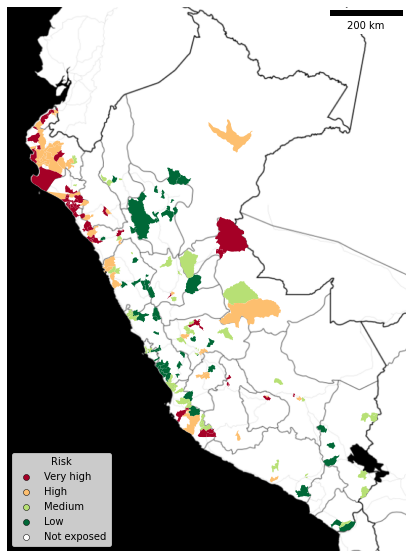

Shock: mass movements
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/mass movements/peru_mass movements_variables_table.csv


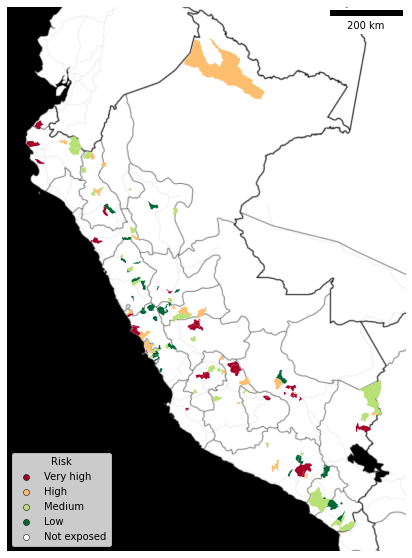

Shock: droughts
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/droughts/peru_droughts_variables_table.csv


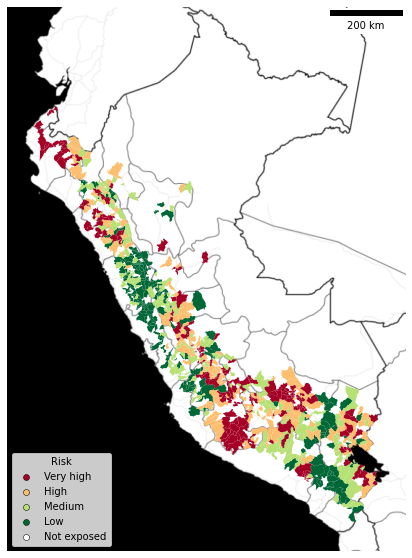

Shock: landslide
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/landslide/peru_landslide_variables_table.csv


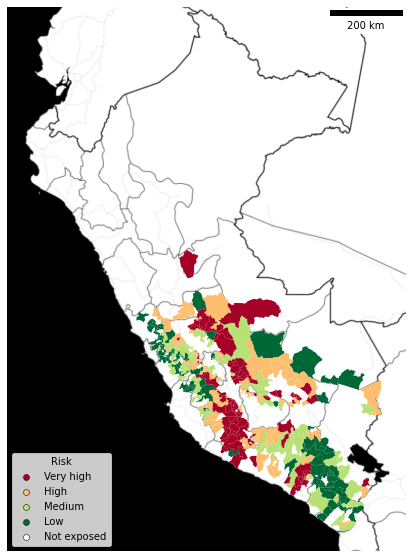

Shock: frost
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/frost/peru_frost_variables_table.csv


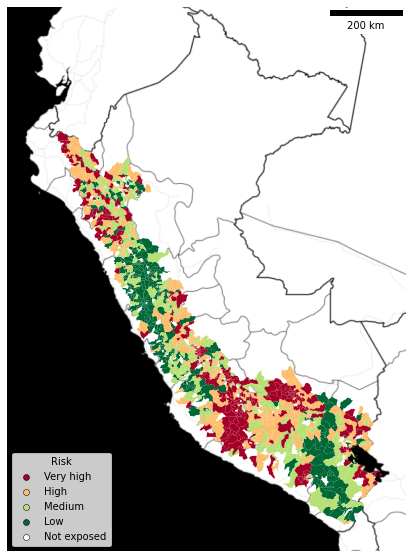

Shock: extreme cold
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/extreme cold/peru_extreme cold_variables_table.csv


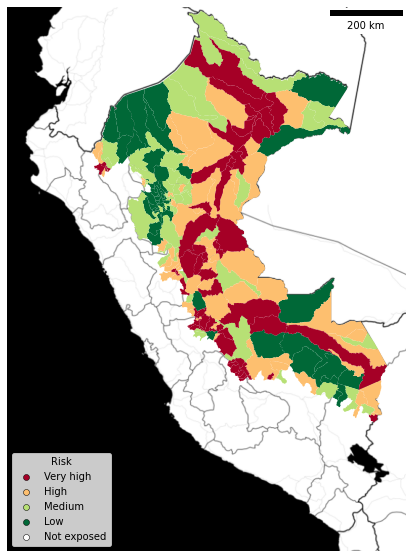

Shock: snow
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/snow/peru_snow_variables_table.csv


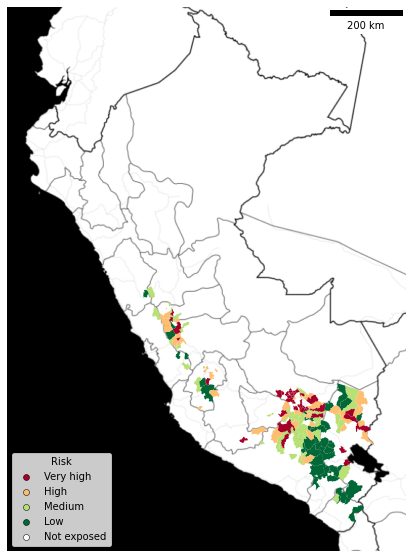

dict_keys(['floods', 'mass movements', 'droughts', 'landslide', 'frost', 'extreme cold', 'snow'])

In [111]:
data_resumen_list = {}
for shock in shock_list:
    print("Shock:", shock)
    data_vector = None

    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
    print("Reading:", path)
    data_vector = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})

    df = data_vector.copy()
    better_values = ["ideal_values"] + ideal_values

    better_values = {
        col_name: pd.Series(val) for col_name, val in zip(df.columns, better_values)
    }
    better_values = pd.DataFrame(better_values)

    data_resumen = pd.concat([better_values, df], ignore_index=True)

    for elem in delete_columns_for[shock]:
        del data_resumen[elem]

    data_resumen = cosine_similarity_df(data_resumen)
    data_resumen = data_resumen.iloc[1:, :]
    data_resumen["Risk To Measure"] = data_resumen["Risk To Measure"].astype(float)

    # CUARTILES
    data_resumen["Risk Tag"] = pd.qcut(data_resumen["Risk To Measure"], 4, labels=False)
    data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 1

    data_resumen = pd.merge(
        fsupport.rename_columns(administrative_areas_dict[ADMINISTRATION_STUDY[:16]]),
        # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
        data_resumen,
        how="right",
        left_on=[
            ADMINISTRATION_STUDY,
        ],
        right_on=[
            ADMINISTRATION_STUDY,
        ],
        sort=True,
        suffixes=("_x", "_y"),
    )  # .sort_values(['CodigoPrestador'], ascending=False)

    data_resumen["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

    # FIGURES --------------------------------

    data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
    col = "Risk Tag"
    data_temp = data_temp.sort_values(by=[col], ascending=[True])

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim([-82.0, -68.0])  # type: ignore # Límites en la coordenada X
    ax.set_ylim([-19.0, 0.1])  # type: ignore # Límites en la coordenada Y
    ax.axis("off")
    cmap_color = "RdYlGn_r"
    # cmap_color = 'RdYlGn'

    norm = fsupport.get_color_scale(data_temp, col)

    plot = data_temp.plot(
        ax=ax,
        column=col,
        cmap=cmap_color,
    )  # legend = True)
    ctx.add_basemap(
        plot,
        crs="epsg:4326",
        source=ctx.providers.Stamen.TonerBackground,
        attribution="",
    )

    A = [
        -70.1 * np.pi / 180.0,
        -2.5 * np.pi / 180.0,
    ]  # set latitude & longitude of interest here
    B = [
        -70.8 * np.pi / 180.0,
        -2.5 * np.pi / 180.0,
    ]  # set latitude & longitude (longitude in A +1) of interest here
    dx = (6371000) * haversine_distances([A, B])[0, 1]
    ax.add_artist(ScaleBar(dx=dx, units="m"))

    # Obtener los valores únicos de vulnerabilidad
    vulnerability_values = data_temp[col].unique()

    # Colores para la leyenda
    cmap = mpl.colormaps.get_cmap("RdYlGn_r")
    points = np.linspace(0, 1, len(vulnerability_values))
    legend_colors = mcolors.ListedColormap(cmap(points))

    # Añadir los puntos y las etiquetas en la leyenda
    labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

    if not fsupport.qty_departments_complete(
        COUNTRY_NAME, len(data_temp), administrative_level=3
    ):
        ax.scatter(
            [],
            [],
            color="white",
            label="Not exposed",
            edgecolors="black",
            linewidths=0.5,
        )

    for i, value in enumerate(vulnerability_values):
        ax.scatter(
            [],
            [],
            color=legend_colors(i),
            label=labels_dict[value],
            edgecolors="black",
            linewidths=0.5,
        )
        # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

    # Mostrar la leyenda
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]

    # Mostrar la leyenda invertida
    ax.legend(handles, labels, title="Risk", loc="lower left")
    # ax.legend(title='Risk', loc='lower right')

    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_quartils_over_distance_figure.png"
    plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

    plt.show()

    data_resumen_to_save = data_resumen.copy()
    del data_resumen_to_save["geometry"]
    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_quartils_over_distance_labeled_table.csv"
    data_resumen_to_save = data_resumen_to_save.sort_values(
        by=["Risk To Measure"], ascending=True
    )
    data_resumen_to_save.to_csv(path, index=False)

    data_resumen_list[shock] = data_temp

data_resumen_list.keys()

### Regiones


In [112]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

if not os.path.exists(f"{directory}/department/"):
    os.makedirs(f"{directory}/department/")

In [113]:
DEPARTAMENTO = ["PIURA"]
# DEPARTAMENTO = ["TACNA"]

Shock: floods
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/floods/peru_floods_variables_table.csv


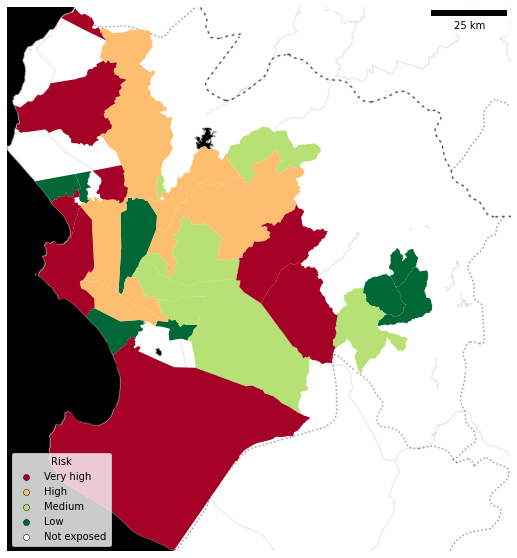

/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


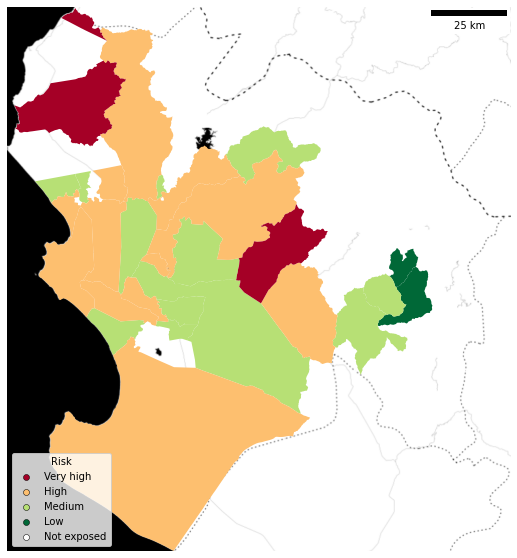

Shock: mass movements
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/mass movements/peru_mass movements_variables_table.csv


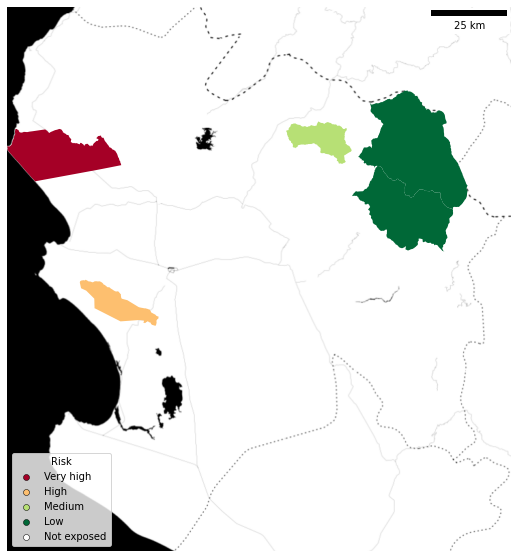

/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


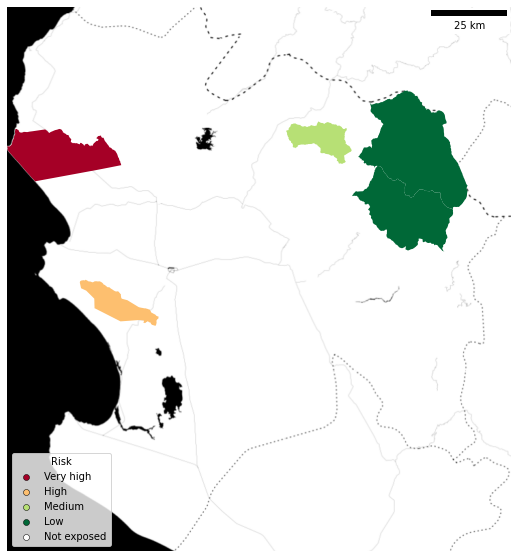

Shock: droughts
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/droughts/peru_droughts_variables_table.csv


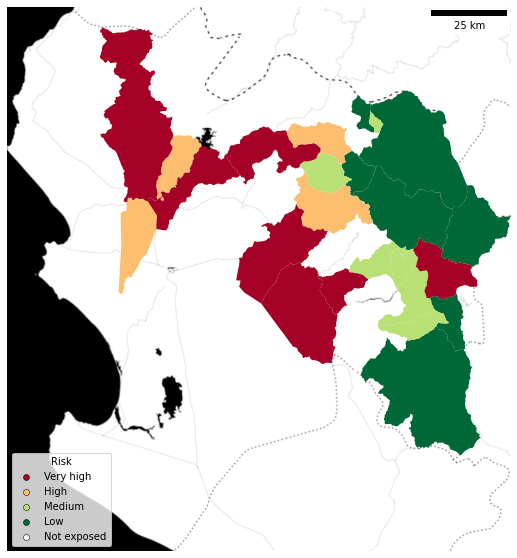

/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


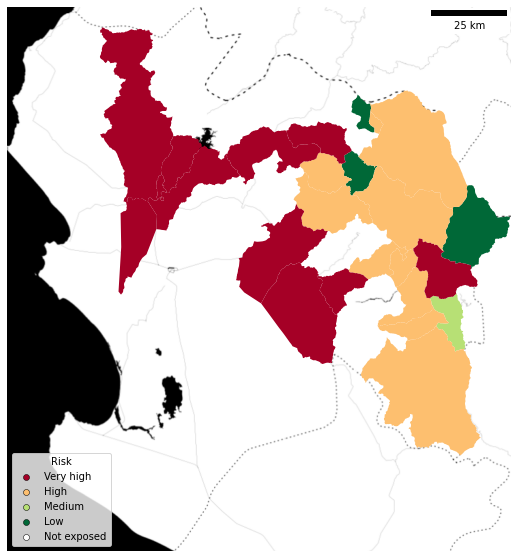

Shock: landslide
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/landslide/peru_landslide_variables_table.csv
Shock: frost
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/frost/peru_frost_variables_table.csv


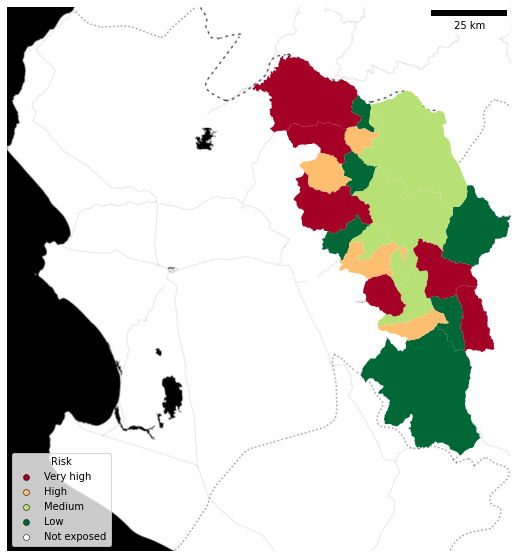

/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


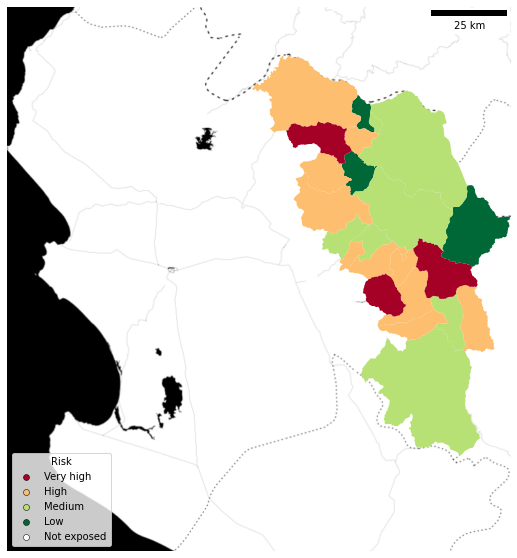

Shock: extreme cold
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/extreme cold/peru_extreme cold_variables_table.csv
Shock: snow
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/snow/peru_snow_variables_table.csv


In [114]:

dept_point = administrative_areas_dict["Administration 1"][
    administrative_areas_dict["Administration 1"]["administration_1"].isin(DEPARTAMENTO)
]["geometry"]
bounds = dept_point.bounds

for shock in shock_list:
    print("Shock:", shock)
    data_vector = None

    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
    print("Reading:", path)
    data_vector = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})
    initial_columns = data_vector.columns
    data_vector = pd.merge(
        fsupport.rename_columns(administrative_areas_dict[ADMINISTRATION_STUDY[:16]]),
        # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
        data_vector,
        how="right",
        left_on=[
            ADMINISTRATION_STUDY,
        ],
        right_on=[
            ADMINISTRATION_STUDY,
        ],
        sort=True,
        suffixes=("_x", "_y"),
    )

    data_vector = data_vector[data_vector["Administration 1"].isin(DEPARTAMENTO)]

    data_resumen = data_vector[initial_columns].copy()
    better_values = ["ideal_values"] + ideal_values

    better_values = {
        col_name: pd.Series(val)
        for col_name, val in zip(data_resumen.columns, better_values)
    }
    better_values = pd.DataFrame(better_values)

    data_resumen_main = pd.concat([better_values, data_resumen], ignore_index=True)

    for elem in delete_columns_for[shock]:
        del data_resumen_main[elem]

    data_resumen_main = cosine_similarity_df(data_resumen_main)
    data_resumen_main = data_resumen_main.iloc[1:, :]
    data_resumen_main["Risk To Measure"] = data_resumen_main["Risk To Measure"].astype(float)

    if len(data_resumen_main) > 0:
        group_number = 4
        if len(data_resumen_main) < 4:
            group_number = len(data_resumen_main) 
            
        # CUARTILES
        data_resumen = data_resumen_main.copy()
        data_resumen["Risk Tag"] = pd.qcut(
            data_resumen["Risk To Measure"], group_number, labels=False
        )
        
        if group_number < 4:
            data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 1 + 4 - group_number
        else:
            data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 1

        data_resumen = pd.merge(
            fsupport.rename_columns(
                administrative_areas_dict[ADMINISTRATION_STUDY[:16]]
            ),
            # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
            data_resumen,
            how="right",
            left_on=[
                ADMINISTRATION_STUDY,
            ],
            right_on=[
                ADMINISTRATION_STUDY,
            ],
            sort=True,
            suffixes=("_x", "_y"),
        )

        data_vector["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

        # FIGURES --------------------------------

        data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
        col = "Risk Tag"
        data_temp = data_temp.sort_values(by=[col], ascending=[True])

        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
        ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
        ax.axis("off")

        cmap_color = "RdYlGn_r"
        # cmap_color = 'RdYlGn'

        norm = fsupport.get_color_scale(data_temp, col)

        plot = data_temp.plot(
            ax=ax,
            column=col,
            cmap=cmap_color,
        )  # legend = True)
        ctx.add_basemap(
            plot,
            crs="epsg:4326",
            source=ctx.providers.Stamen.TonerBackground,
            attribution="",
        )

        A = [
            -70.1 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude of interest here
        B = [
            -70.8 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude (longitude in A +1) of interest here
        dx = (6371000) * haversine_distances([A, B])[0, 1]
        ax.add_artist(ScaleBar(dx=dx, units="m"))

        # Obtener los valores únicos de vulnerabilidad
        vulnerability_values = data_temp[col].unique()

        # Colores para la leyenda
        cmap = mpl.colormaps.get_cmap("RdYlGn_r")
        points = np.linspace(0, 1, len(vulnerability_values))
        legend_colors = mcolors.ListedColormap(cmap(points))

        # Añadir los puntos y las etiquetas en la leyenda
        labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

        if not fsupport.qty_departments_complete(
            COUNTRY_NAME, len(data_temp), administrative_level=3
        ):
            ax.scatter(
                [],
                [],
                color="white",
                label="Not exposed",
                edgecolors="black",
                linewidths=0.5,
            )

        for i, value in enumerate(vulnerability_values):
            ax.scatter(
                [],
                [],
                color=legend_colors(i),
                label=labels_dict[value],
                edgecolors="black",
                linewidths=0.5,
            )
            # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

        # Mostrar la leyenda
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]

        # Mostrar la leyenda invertida
        ax.legend(handles, labels, title="Risk", loc="lower left")
        # ax.legend(title='Risk', loc='lower right')

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_adm1_{shock}_quartils_risk_figure.png"
        plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

        plt.show()

        data_resumen_to_save = data_resumen.copy()
        del data_resumen_to_save["geometry"]
        data_resumen_to_save = data_resumen_to_save.sort_values(
            by=["Risk To Measure"], ascending=True
        )

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_adm1_{shock}_quartils_risk_table.csv"
        data_resumen_to_save.to_csv(path, index=False)

    if len(data_resumen_main) > 0:
        
        group_number = 4
        if len(data_resumen_main) <= 4:
            group_number = len(data_resumen_main) 
            
        # K-MEANS --------------------------------
        data_resumen = data_resumen_main.copy()
        data_resumen["Risk To Measure"] = data_resumen["Risk To Measure"].astype(float)
        X = data_resumen[["Risk To Measure"]]
        kmeans = KMeans(n_clusters=group_number, random_state=42).fit(X)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_.tolist()
        centroids_order = sorted(centroids, key=lambda x: x)
        index_orders = [centroids.index(x) for x in centroids_order]
        labels_order = [index_orders.index(i) + 1 for i in labels]
        data_resumen["Risk Tag"] = labels_order
        if group_number < 4:
            data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 4 - group_number
        

        data_resumen = pd.merge(
            fsupport.rename_columns(
                administrative_areas_dict[ADMINISTRATION_STUDY[:16]]
            ),
            # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
            data_resumen,
            how="right",
            left_on=[
                ADMINISTRATION_STUDY,
            ],
            right_on=[
                ADMINISTRATION_STUDY,
            ],
            sort=True,
            suffixes=("_x", "_y"),
        )
        data_vector["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

        # FIGURES --------------------------------

        data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
        col = "Risk Tag"
        data_temp = data_temp.sort_values(by=[col], ascending=[True])

        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
        ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
        ax.axis("off")

        cmap_color = "RdYlGn_r"
        # cmap_color = 'RdYlGn'

        norm = fsupport.get_color_scale(data_temp, col)

        plot = data_temp.plot(
            ax=ax,
            column=col,
            cmap=cmap_color,
        )  # legend = True)
        ctx.add_basemap(
            plot,
            crs="epsg:4326",
            source=ctx.providers.Stamen.TonerBackground,
            attribution="",
        )

        A = [
            -70.1 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude of interest here
        B = [
            -70.8 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude (longitude in A +1) of interest here
        dx = (6371000) * haversine_distances([A, B])[0, 1]
        ax.add_artist(ScaleBar(dx=dx, units="m"))

        # Obtener los valores únicos de vulnerabilidad
        vulnerability_values = data_temp[col].unique()

        # Colores para la leyenda
        cmap = mpl.colormaps.get_cmap("RdYlGn_r")
        points = np.linspace(0, 1, len(vulnerability_values))
        legend_colors = mcolors.ListedColormap(cmap(points))

        # Añadir los puntos y las etiquetas en la leyenda
        labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

        if not fsupport.qty_departments_complete(
            COUNTRY_NAME, len(data_temp), administrative_level=3
        ):
            ax.scatter(
                [],
                [],
                color="white",
                label="Not exposed",
                edgecolors="black",
                linewidths=0.5,
            )

        for i, value in enumerate(vulnerability_values):
            ax.scatter(
                [],
                [],
                color=legend_colors(i),
                label=labels_dict[value],
                edgecolors="black",
                linewidths=0.5,
            )
            # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

        # Mostrar la leyenda
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]

        # Mostrar la leyenda invertida
        ax.legend(handles, labels, title="Risk", loc="lower left")
        # ax.legend(title='Risk', loc='lower right')

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_adm1_{shock}_kmeans_risk_figure.png"
        plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

        plt.show()

        data_resumen_to_save = data_resumen.copy()
        del data_resumen_to_save["geometry"]
        data_resumen_to_save = data_resumen_to_save.sort_values(
            by=["Risk To Measure"], ascending=True
        )

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_adm1_{shock}_kmeans_risk_table.csv"
        data_resumen_to_save.to_csv(path, index=False)
        
        

# data_resumen_list.keys()

In [115]:
DEPARTAMENTO = ["LIMA", "CALLAO"]

Shock: floods
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/floods/peru_floods_variables_table.csv


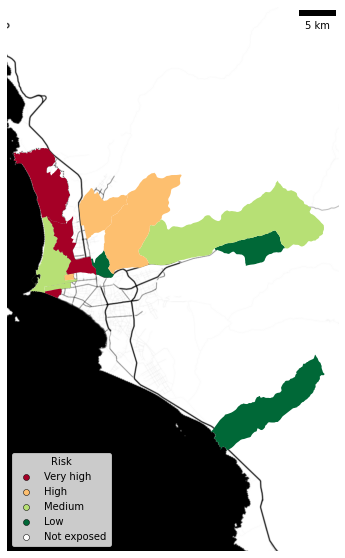

/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


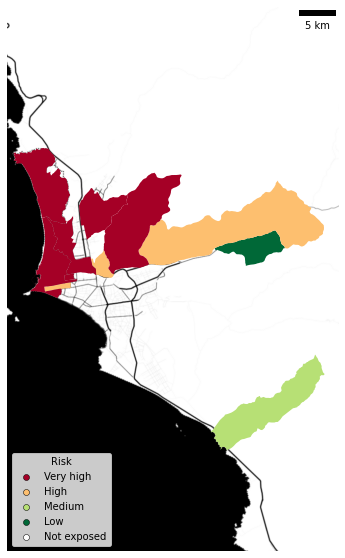

Shock: mass movements
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/mass movements/peru_mass movements_variables_table.csv


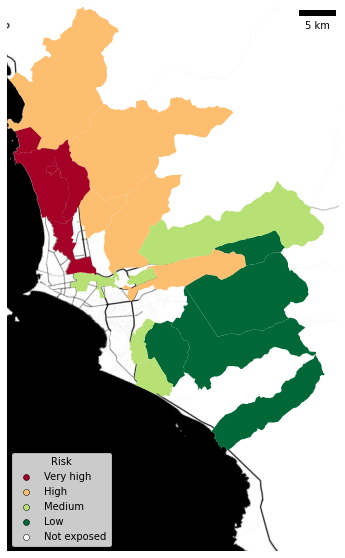

/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


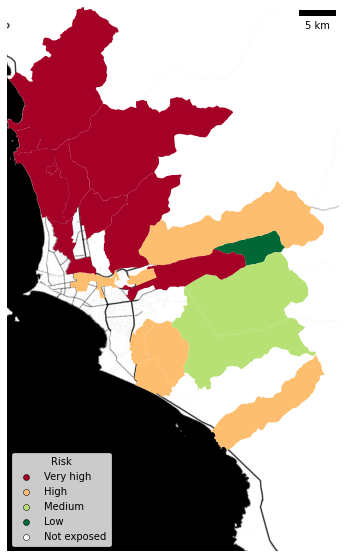

Shock: droughts
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/droughts/peru_droughts_variables_table.csv
Shock: landslide
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/landslide/peru_landslide_variables_table.csv
Shock: frost
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/frost/peru_frost_variables_table.csv


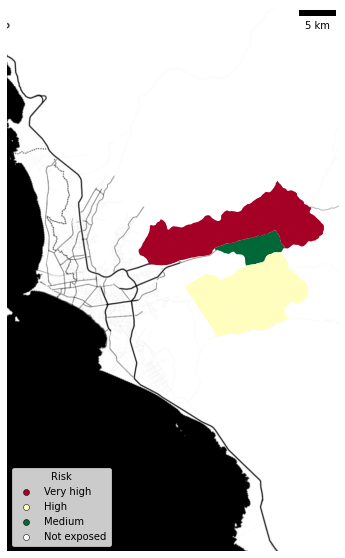

/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


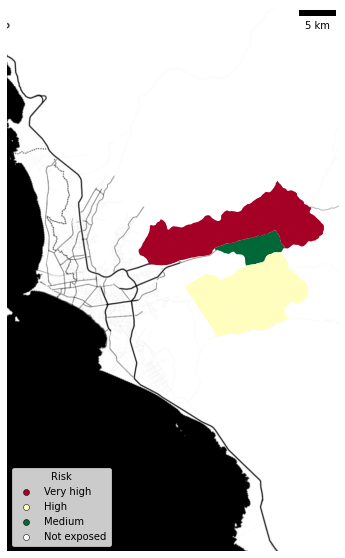

Shock: extreme cold
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/extreme cold/peru_extreme cold_variables_table.csv
Shock: snow
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/snow/peru_snow_variables_table.csv


In [116]:
# data_resumen_list = {}

# DEPARTAMENTO = 'TACNA'
dept_point = administrative_areas_dict["Administration 2"][
    administrative_areas_dict["Administration 2"]["administration_2"].isin(DEPARTAMENTO)
]["geometry"]
bounds = dept_point.bounds

for shock in shock_list:
    print("Shock:", shock)
    data_vector = None

    path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
    print("Reading:", path)
    data_vector = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})
    initial_columns = data_vector.columns
    data_vector = pd.merge(
        fsupport.rename_columns(administrative_areas_dict[ADMINISTRATION_STUDY[:16]]),
        # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
        data_vector,
        how="right",
        left_on=[
            ADMINISTRATION_STUDY,
        ],
        right_on=[
            ADMINISTRATION_STUDY,
        ],
        sort=True,
        suffixes=("_x", "_y"),
    )

    data_vector = data_vector[data_vector["Administration 2"].isin(DEPARTAMENTO)]

    data_resumen = data_vector[initial_columns].copy()
    better_values = ["ideal_values"] + ideal_values

    better_values = {
        col_name: pd.Series(val)
        for col_name, val in zip(data_resumen.columns, better_values)
    }
    better_values = pd.DataFrame(better_values)

    data_resumen_main = pd.concat([better_values, data_resumen], ignore_index=True)

    for elem in delete_columns_for[shock]:
        del data_resumen_main[elem]

    data_resumen_main = cosine_similarity_df(data_resumen_main)
    data_resumen_main = data_resumen_main.iloc[1:, :]
    data_resumen_main["Risk To Measure"] = data_resumen_main["Risk To Measure"].astype(float)

    if len(data_resumen_main) > 0:
        
        group_number = 4
        if len(data_resumen_main) < 4:
            group_number = len(data_resumen_main) 
            
        # CUARTILES --------------------------------
        data_resumen = data_resumen_main.copy()
        data_resumen["Risk Tag"] = pd.qcut(
            data_resumen["Risk To Measure"], group_number, labels=False
        )
        
        if group_number < 4:
            data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 1 + 4 - group_number
        else:
            data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 1

        data_resumen = pd.merge(
            fsupport.rename_columns(
                administrative_areas_dict[ADMINISTRATION_STUDY[:16]]
            ),
            # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
            data_resumen,
            how="right",
            left_on=[
                ADMINISTRATION_STUDY,
            ],
            right_on=[
                ADMINISTRATION_STUDY,
            ],
            sort=True,
            suffixes=("_x", "_y"),
        )

        data_vector["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

        # FIGURES --------------------------------

        data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
        col = "Risk Tag"
        data_temp = data_temp.sort_values(by=[col], ascending=[True])

        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
        ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
        ax.axis("off")

        cmap_color = "RdYlGn_r"
        # cmap_color = 'RdYlGn'

        norm = fsupport.get_color_scale(data_temp, col)

        plot = data_temp.plot(
            ax=ax,
            column=col,
            cmap=cmap_color,
        )  # legend = True)
        ctx.add_basemap(
            plot,
            crs="epsg:4326",
            source=ctx.providers.Stamen.TonerBackground,
            attribution="",
        )

        A = [
            -70.1 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude of interest here
        B = [
            -70.8 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude (longitude in A +1) of interest here
        dx = (6371000) * haversine_distances([A, B])[0, 1]
        ax.add_artist(ScaleBar(dx=dx, units="m"))

        # Obtener los valores únicos de vulnerabilidad
        vulnerability_values = data_temp[col].unique()

        # Colores para la leyenda
        cmap = mpl.colormaps.get_cmap("RdYlGn_r")
        points = np.linspace(0, 1, len(vulnerability_values))
        legend_colors = mcolors.ListedColormap(cmap(points))

        # Añadir los puntos y las etiquetas en la leyenda
        labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

        if not fsupport.qty_departments_complete(
            COUNTRY_NAME, len(data_temp), administrative_level=3
        ):
            ax.scatter(
                [],
                [],
                color="white",
                label="Not exposed",
                edgecolors="black",
                linewidths=0.5,
            )

        for i, value in enumerate(vulnerability_values):
            ax.scatter(
                [],
                [],
                color=legend_colors(i),
                label=labels_dict[value],
                edgecolors="black",
                linewidths=0.5,
            )
            # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

        # Mostrar la leyenda
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]
        
        # Mostrar la leyenda invertida
        ax.legend(handles, labels, title="Risk", loc="lower left")
        # ax.legend(title='Risk', loc='lower right')

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_{shock}_adm2_quartils_risk_figure.png"
        plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

        plt.show()

        data_resumen_to_save = data_resumen.copy()
        del data_resumen_to_save["geometry"]
        data_resumen_to_save = data_resumen_to_save.sort_values(
            by=["Risk To Measure"], ascending=True
        )

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_{shock}_adm2_quartils_risk_table.csv"
        data_resumen_to_save.to_csv(path, index=False)



    if len(data_resumen_main) > 0:
        
        group_number = 4
        if len(data_resumen_main) <= 4:
            group_number = len(data_resumen_main) 
        
        # MEANS --------------------------------
        data_resumen = data_resumen_main.copy()
        data_resumen["Risk To Measure"] = data_resumen["Risk To Measure"].astype(float)
        X = data_resumen[["Risk To Measure"]]
        kmeans = KMeans(n_clusters=group_number, random_state=42).fit(X)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_.tolist()
        centroids_order = sorted(centroids, key=lambda x: x)
        index_orders = [centroids.index(x) for x in centroids_order]
        labels_order = [index_orders.index(i) + 1 for i in labels]
        data_resumen["Risk Tag"] = labels_order
        if group_number < 4:
            data_resumen["Risk Tag"] = data_resumen["Risk Tag"] + 4 - group_number
        

        data_resumen = pd.merge(
            fsupport.rename_columns(
                administrative_areas_dict[ADMINISTRATION_STUDY[:16]]
            ),
            # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
            data_resumen,
            how="right",
            left_on=[
                ADMINISTRATION_STUDY,
            ],
            right_on=[
                ADMINISTRATION_STUDY,
            ],
            sort=True,
            suffixes=("_x", "_y"),
        )
        data_vector["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

        # FIGURES --------------------------------

        data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
        col = "Risk Tag"
        data_temp = data_temp.sort_values(by=[col], ascending=[True])

        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
        ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
        ax.axis("off")

        cmap_color = "RdYlGn_r"
        # cmap_color = 'RdYlGn'

        norm = fsupport.get_color_scale(data_temp, col)

        plot = data_temp.plot(
            ax=ax,
            column=col,
            cmap=cmap_color,
        )  # legend = True)
        ctx.add_basemap(
            plot,
            crs="epsg:4326",
            source=ctx.providers.Stamen.TonerBackground,
            attribution="",
        )

        A = [
            -70.1 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude of interest here
        B = [
            -70.8 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude (longitude in A +1) of interest here
        dx = (6371000) * haversine_distances([A, B])[0, 1]
        ax.add_artist(ScaleBar(dx=dx, units="m"))

        # Obtener los valores únicos de vulnerabilidad
        vulnerability_values = data_temp[col].unique()

        # Colores para la leyenda
        cmap = mpl.colormaps.get_cmap("RdYlGn_r")
        points = np.linspace(0, 1, len(vulnerability_values))
        legend_colors = mcolors.ListedColormap(cmap(points))

        # Añadir los puntos y las etiquetas en la leyenda
        labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

        if not fsupport.qty_departments_complete(
            COUNTRY_NAME, len(data_temp), administrative_level=3
        ):
            ax.scatter(
                [],
                [],
                color="white",
                label="Not exposed",
                edgecolors="black",
                linewidths=0.5,
            )

        for i, value in enumerate(vulnerability_values):
            ax.scatter(
                [],
                [],
                color=legend_colors(i),
                label=labels_dict[value],
                edgecolors="black",
                linewidths=0.5,
            )
            # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

        # Mostrar la leyenda
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]

        # Mostrar la leyenda invertida
        ax.legend(handles, labels, title="Risk", loc="lower left")
        # ax.legend(title='Risk', loc='lower right')

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_{shock}_adm2_kmeans_risk_figure.png"
        plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

        plt.show()

        data_resumen_to_save = data_resumen.copy()
        del data_resumen_to_save["geometry"]
        data_resumen_to_save = data_resumen_to_save.sort_values(
            by=["Risk To Measure"], ascending=True
        )

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_{shock}_adm2_kmeans_risk_table.csv"
        data_resumen_to_save.to_csv(path, index=False)
        
        


# data_resumen_list.keys()

In [117]:
DEPARTAMENTO = ["PIURA"]
# DEPARTAMENTO = ["TACNA"]

floods
/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/department/peru_PIURA_adm1_floods_exposed_area.png


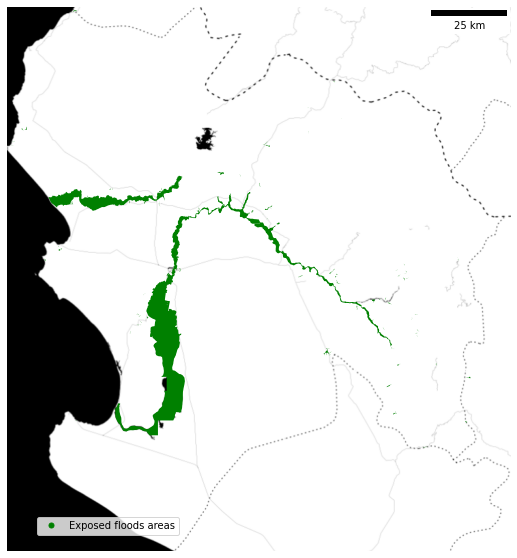

mass movements
/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/department/peru_PIURA_adm1_mass movements_exposed_area.png


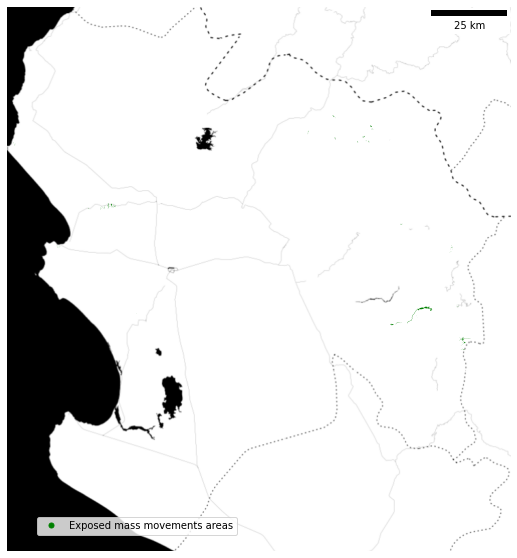

droughts
/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/department/peru_PIURA_adm1_droughts_exposed_area.png


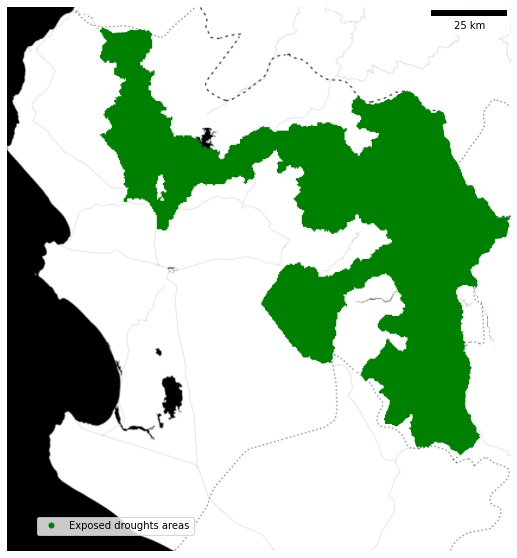

landslide
frost
/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/department/peru_PIURA_adm1_frost_exposed_area.png


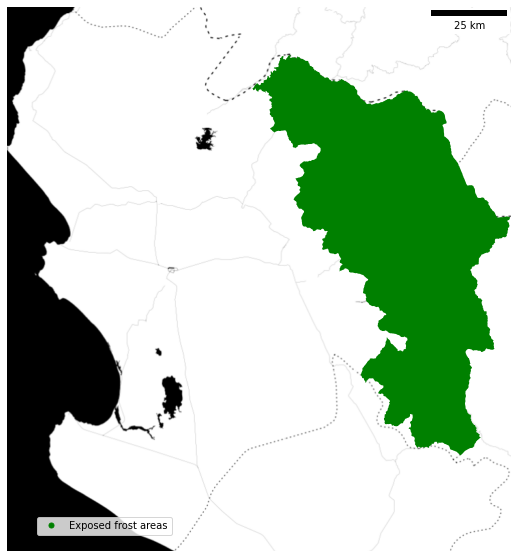

extreme cold
snow


In [118]:
for shock in shock_list:
    print(shock)
    # path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_quartils_over_distance_labeled_table.csv"
    # path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"

    # DEPARTAMENTO = 'TACNA'
    dept_point = administrative_areas_dict["Administration 1"][
        administrative_areas_dict["Administration 1"]["administration_1"].isin(DEPARTAMENTO)
    ]["geometry"]
    bounds = dept_point.bounds

    """
    Plot map shock
    """

    # Reading shape
    path_shock_file = shock_dict[shock]
    shock_shape = fsupport.shock_shape(path=path_shock_file, shock_name=shock)
    shock_shape = shock_shape.intersection(list(dept_point)[0])

    # if len(shock_shape) > 0:

    if ~(shock_shape.is_empty.values[0]):
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
        ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
        ax.axis("off")

        # plot = shock_shape.plot(ax=ax, marker=".", color="gray", markersize=1, alpha=0.2)
        plot = shock_shape.plot(ax=ax, marker=".", color="green", markersize=1)

        ctx.add_basemap(
            plot,
            crs="epsg:4326",
            source=ctx.providers.Stamen.TonerBackground,
            attribution="",
        )

        # set latitude & longitude of interest here
        A = [-70.1 * np.pi / 180.0, -2.5 * np.pi / 180.0]
        # set latitude & longitude (longitude in A +1) of interest here
        B = [-70.8 * np.pi / 180.0, -2.5 * np.pi / 180.0]
        dx = (6371000) * haversine_distances([A, B])[0, 1]
        ax.add_artist(ScaleBar(dx=dx, units="m"))

        # Legend
        red_dots = Line2D(
            [0],
            [0],
            marker="o",
            color="green",
            markerfacecolor="green",
            label=f"Exposed {shock} areas",
            markersize=5,
            linewidth=0,
        )
        ax.legend(
            title="", handles=[red_dots], bbox_to_anchor=(0.05, 0.02), loc="lower left"
        )

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_adm1_{shock}_exposed_area.png"
        plt.savefig(path, format="png", dpi=150, bbox_inches="tight")
        print(path)

        plt.show()
        plt.close(fig)

In [119]:
for shock in shock_list:
    print(shock)
    # path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_quartils_over_distance_labeled_table.csv"
    # path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"

    # DEPARTAMENTO = 'TACNA'
    dept_point = administrative_areas_dict["Administration 1"][
        administrative_areas_dict["Administration 1"]["administration_1"].isin(DEPARTAMENTO)
    ]["geometry"]
    bounds = dept_point.bounds

    # POPULATION EXPOSED FOR
    path = (
        f"{directory}/{shock}/{COUNTRY_NAME}_exposed_population_{shock}_adm3_table.csv"
    )
    data_temp = pd.read_csv(path, dtype={"Administration 3 Code": str})

    data_temp = data_temp[data_temp["Administration 1"].isin(DEPARTAMENTO)]
    data_temp = pd.merge(
        data_temp,
        administrative_areas_dict["Administration 3"][
            ["administration_3_code", "geometry"]
        ],
        how="left",
        left_on=["Administration 3 Code"],
        right_on=["administration_3_code"],
    )

    data_temp = gpd.GeoDataFrame(data_temp, geometry="geometry")

    """
    Plot map intensity
    """
    transform_column = 0
    cmap_color = "Blues"
    leg_color = "Blue"
    column_name = "Percentage"
    trasformed_column = "temporal_column"

    if transform_column < 0:
        data_temp[trasformed_column] = data_temp[column_name].apply(
            lambda x: pow(x, 1 / -1 * transform_column)
        )
    elif transform_column > 0:
        data_temp[trasformed_column] = data_temp[column_name].apply(
            lambda x: pow(x, transform_column)
        )
    else:
        data_temp[trasformed_column] = data_temp[column_name]

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
    ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
    ax.axis("off")

    norm = fsupport.get_color_scale(data_temp, trasformed_column)

    plot = data_temp.plot(ax=ax, column=trasformed_column, cmap=cmap_color)
    ctx.add_basemap(
        plot,
        crs="epsg:4326",
        source=ctx.providers.Stamen.TonerBackground,
        attribution="",
    )

    # set latitude & longitude of interest here
    A = [-70.1 * np.pi / 180.0, -2.5 * np.pi / 180.0]
    # set latitude & longitude (longitude in A +1) of interest here
    B = [-70.8 * np.pi / 180.0, -2.5 * np.pi / 180.0]
    dx = (6371000) * haversine_distances([A, B])[0, 1]
    ax.add_artist(ScaleBar(dx=dx, units="m"))

    ticks = np.linspace(
        data_temp[trasformed_column].min(),
        data_temp[trasformed_column].max(),
        num=5,
        dtype=float,
    )

    labels = np.linspace(
        data_temp[column_name].min(), data_temp[column_name].max(), num=5, dtype=int
    )
    labels = [f"{x}%" for x in labels]

    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.05,
            ax.get_position().y0,
            0.01,
            ax.get_position().height,
        ]
    )
    cbar = fig.colorbar(
        cm.ScalarMappable(norm=norm, cmap=cmap_color),
        cax=cax,
        orientation="vertical",
        label="",
        ticks=ticks,
    )

    cbar.ax.set_yticklabels(labels)

    # Legend
    red_dots = Line2D(
        [0],
        [0],
        marker="o",
        color=leg_color,
        markerfacecolor=leg_color,
        label="Percent of exposed population",
        markersize=5,
        linewidth=0,
    )
    ax.legend(
        title="", handles=[red_dots], bbox_to_anchor=(0.05, 0.02), loc="lower left"
    )

    path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_{shock}_exposed_population.png"
    plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

    # plt.show()
    plt.close(fig)

    # INFRA EXPOSED FOR
    path = f"{directory}/{shock}/{COUNTRY_NAME}_exposed_health_infrastructure_{shock}_adm3_table.csv"
    # path = f"{directory}/{shock}/{COUNTRY_NAME}_exposed_health_infrastructure_{shock}_adm2_table.csv"
    data_temp = pd.read_csv(
        path,
        dtype={
            "Administration 1 Code": str,
            "Administration 2 Code": str,
            "Administration 3 Code": str,
        },
    )

    data_temp = data_temp[data_temp["Administration 1"].isin(DEPARTAMENTO)]
    data_temp = pd.merge(
        data_temp,
        administrative_areas_dict["Administration 3"][
            ["administration_3_code", "geometry"]
        ],
        # administrative_areas_dict['Administration 2'][['administration_2_code', 'geometry']],
        how="left",
        left_on=["Administration 3 Code"],
        right_on=["administration_3_code"],
    )

    data_temp = gpd.GeoDataFrame(data_temp, geometry="geometry")

    """
    Plot map intensity

    """
    for CATEGORY in ["I", "II", "III"]:
        print(f"       ...for category: {CATEGORY}")

        transform_column = 0
        cmap_color = "Reds"
        leg_color = "Red"
        column_name = "Percentage Category " + CATEGORY
        trasformed_column = "temporal_column"

        if transform_column < 0:
            data_temp[trasformed_column] = data_temp[column_name].apply(
                lambda x: pow(x, 1 / -1 * transform_column)
            )
        elif transform_column > 0:
            data_temp[trasformed_column] = data_temp[column_name].apply(
                lambda x: pow(x, transform_column)
            )
        else:
            data_temp[trasformed_column] = data_temp[column_name]

        norm = fsupport.get_color_scale(data_temp, trasformed_column)

        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim([bounds["minx"].min(), bounds["maxx"].max()])  # type: ignore # Límites en la coordenada X
        ax.set_ylim([bounds["miny"].min(), bounds["maxy"].max()])  # type: ignore # Límites en la coordenada Y
        ax.axis("off")

        plot = data_temp.plot(
            ax=ax,
            column=trasformed_column,
            cmap=cmap_color,
        )
        ctx.add_basemap(
            plot,
            crs="epsg:4326",
            source=ctx.providers.Stamen.TonerBackground,
            attribution="",
        )

        # set latitude & longitude of interest here
        A = [-70.1 * np.pi / 180.0, -2.5 * np.pi / 180.0]
        B = [-70.8 * np.pi / 180.0, -2.5 * np.pi / 180.0]
        dx = (6371000) * haversine_distances([A, B])[0, 1]
        ax.add_artist(ScaleBar(dx=dx, units="m"))

        ticks = np.linspace(
            data_temp[trasformed_column].min(),
            data_temp[trasformed_column].max(),
            num=5,
            dtype=float,
        )

        labels = np.linspace(
            data_temp[column_name].min(), data_temp[column_name].max(), num=5, dtype=int
        )
        labels = [f"{x}%" for x in labels]

        cax = fig.add_axes(
            [
                ax.get_position().x1 + 0.05,
                ax.get_position().y0,
                0.01,
                ax.get_position().height,
            ]
        )
        cbar = fig.colorbar(
            cm.ScalarMappable(norm=norm, cmap=cmap_color),
            cax=cax,
            orientation="vertical",
            label="",
            ticks=ticks,
        )

        cbar.ax.set_yticklabels(labels)
        # Legend
        red_dots = Line2D(
            [0],
            [0],
            marker="o",
            color=leg_color,
            markerfacecolor=leg_color,
            label=f"Percent of exposed healthcare infrastructure (category {CATEGORY})",
            markersize=5,
            linewidth=0,
        )
        ax.legend(
            title="", handles=[red_dots], bbox_to_anchor=(0.05, 0.02), loc="lower left"
        )

        path = f"{directory}/department/{COUNTRY_NAME}_{'_'.join(DEPARTAMENTO)}_{shock}_cat-{CATEGORY}_infra_population.png"
        plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

        # plt.show()
        plt.close(fig)

floods
       ...for category: I
       ...for category: II
       ...for category: III
mass movements
       ...for category: I
       ...for category: II
       ...for category: III
droughts
       ...for category: I
       ...for category: II
       ...for category: III
landslide
       ...for category: I
       ...for category: II
       ...for category: III
frost
       ...for category: I
       ...for category: II
       ...for category: III
extreme cold
       ...for category: I
       ...for category: II
       ...for category: III
snow
       ...for category: I
       ...for category: II
       ...for category: III


In [120]:
data_temp[
    [
        "Administration 1",
        "Administration 2",
        "Administration 3",
        "Percentage Category I",
        "Percentage Category II",
        "Percentage Category III",
        "geometry",
    ]
]

Administration 1 Administration 2   Administration 3   
0             PIURA            PAITA              COLAN  \
1             PIURA          SECHURA  RINCONADA LLICUAR   
2             PIURA          SECHURA               VICE   
3             PIURA          SECHURA   CRISTO NOS VALGA   
4             PIURA          SECHURA             BERNAL   
..              ...              ...                ...   
60            PIURA      HUANCABAMBA        HUANCABAMBA   
61            PIURA          AYABACA               SUYO   
62            PIURA          AYABACA            SICCHEZ   
63            PIURA          AYABACA          SAPILLICA   
64            PIURA          AYABACA             PAIMAS   

    Percentage Category I  Percentage Category II  Percentage Category III   
0                     0.0                     0.0                      0.0  \
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     0.0                      0.0   
..                    ...                     ...                      ...   
60                    0.0                     0.0                      0.0   
61                    0.0                     0.0                      0.0   
62                    0.0                     0.0                      0.0   
63                    0.0                     0.0                      0.0   
64                    0.0                     0.0                      0.0   

                                             geometry  
0   POLYGON ((-81.03431 -4.85044, -81.03342 -4.850...  
1   POLYGON ((-80.75856 -5.44451, -80.75710 -5.444...  
2   POLYGON ((-80.95976 -5.35072, -80.95924 -5.350...  
3   POLYGON ((-80.66661 -5.48247, -80.64694 -5.487...  
4   POLYGON ((-80.70416 -5.42479, -80.70377 -5.424...  
..                                                ...  
60  POLYGON ((-79.59167 -5.05742, -79.59076 -5.057...  
61  POLYGON ((-80.13576 -4.28533, -80.13554 -4.285...  
62  POLYGON ((-79.79750 -4.52182, -79.79737 -4.521...  
63  POLYGON ((-80.00975 -4.69110, -80.00985 -4.691...  
64  POLYGON ((-80.01833 -4.56466, -80.01742 -4.565...  

[65 rows x 7 columns]

<Axes: >

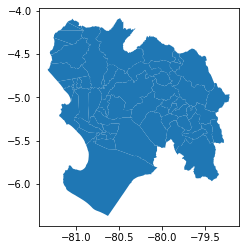

In [121]:
data_temp.plot()

## KMEANS


Shock: floods
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/floods/peru_floods_variables_table.csv
[[0.647524357214506], [0.775642198111256], [0.8356935068693577], [0.86994401332528]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


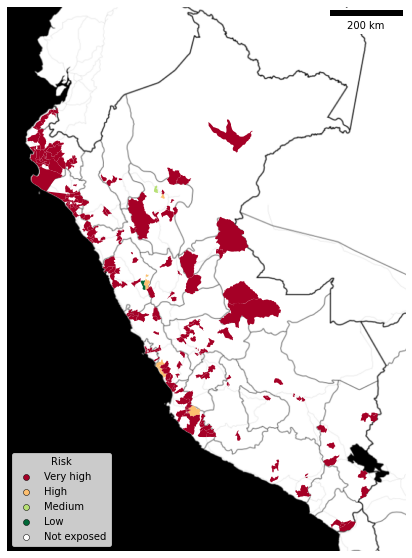

Shock: mass movements
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/mass movements/peru_mass movements_variables_table.csv
[[0.6475237575461144], [0.7924454718642394], [0.851037422455757], [0.8693689994434867]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


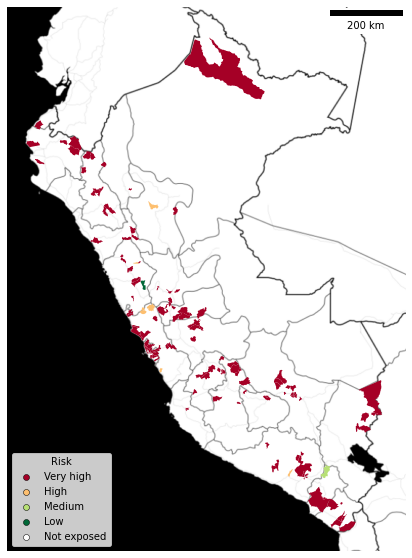

Shock: droughts
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/droughts/peru_droughts_variables_table.csv
[[0.6438141641638289], [0.810040182759215], [0.8505970848154897], [0.8683487656614298]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


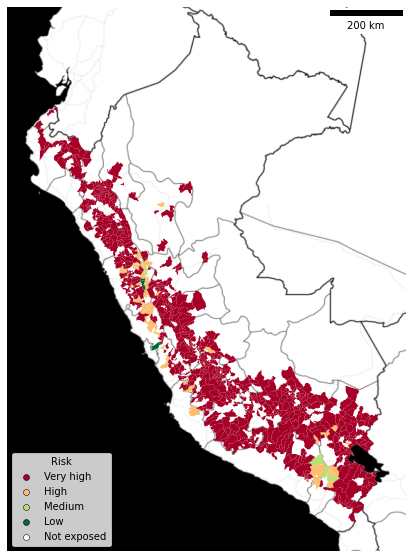

Shock: landslide
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/landslide/peru_landslide_variables_table.csv
[[0.6326053047540297], [0.813797733660915], [0.8564074207976191], [0.8688888386973831]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


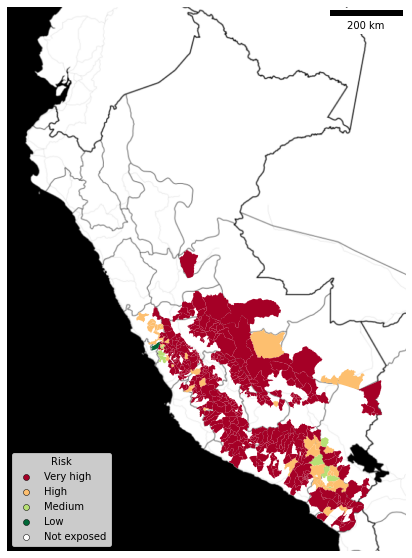

Shock: frost
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/frost/peru_frost_variables_table.csv
[[0.6438145358744246], [0.8105229064511837], [0.8509280204211562], [0.8683584683560778]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


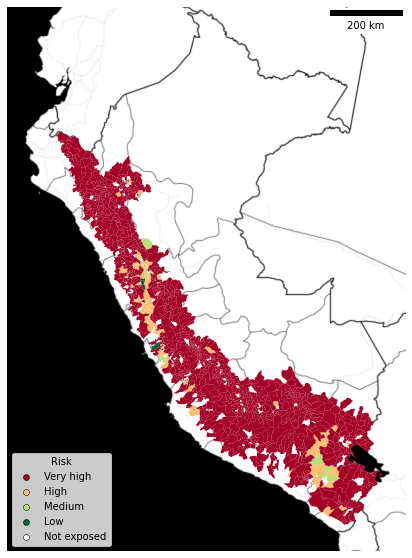

Shock: extreme cold
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/extreme cold/peru_extreme cold_variables_table.csv
[[0.30475914118667613], [0.7524456347924351], [0.8317175490381905], [0.8681494814734712]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


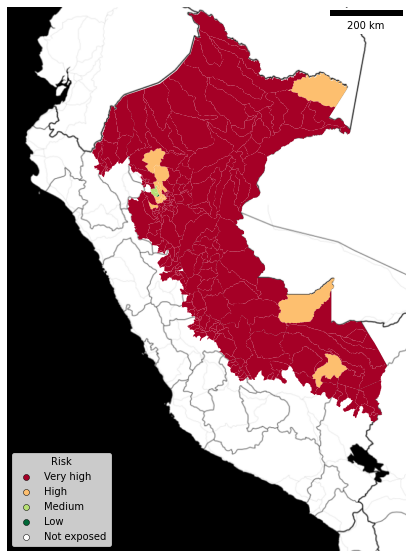

Shock: snow
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/snow/peru_snow_variables_table.csv


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[0.7969353709521865], [0.845801727722448], [0.8618817100408703], [0.8694578587759128]]


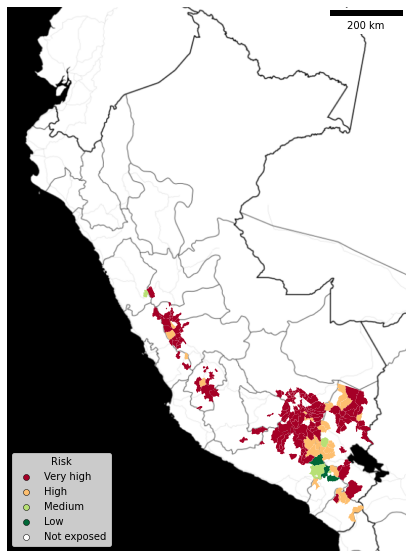

Shock: floods
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/floods/peru_floods_variables_table.csv
[[0.647524357214506], [0.775642198111256], [0.8313695268619833], [0.8590795620271494], [0.8703827764810769]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


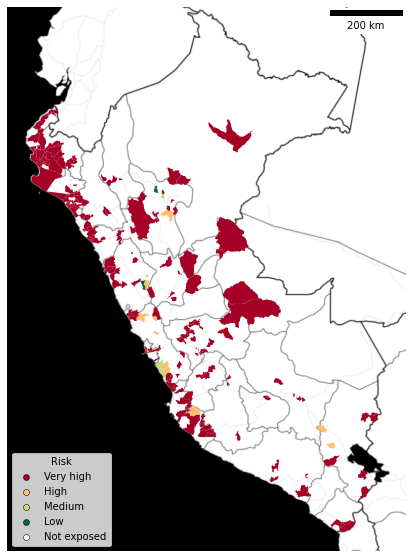

Shock: mass movements
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/mass movements/peru_mass movements_variables_table.csv
[[0.6475237575461144], [0.7924454718642394], [0.8457666701918237], [0.8636496264710646], [0.8700025279567796]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


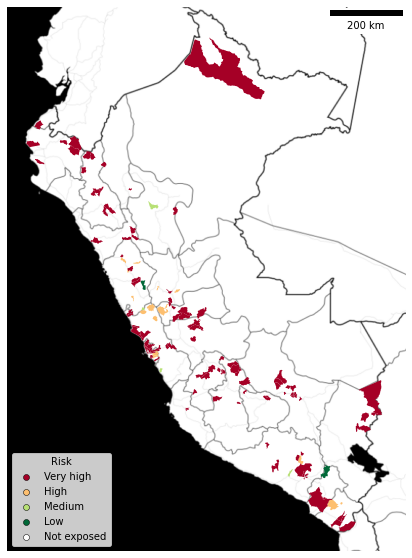

Shock: droughts
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/droughts/peru_droughts_variables_table.csv
[[0.6438141641638289], [0.810040182759215], [0.8433429853592026], [0.861244496323007], [0.869231650005267]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


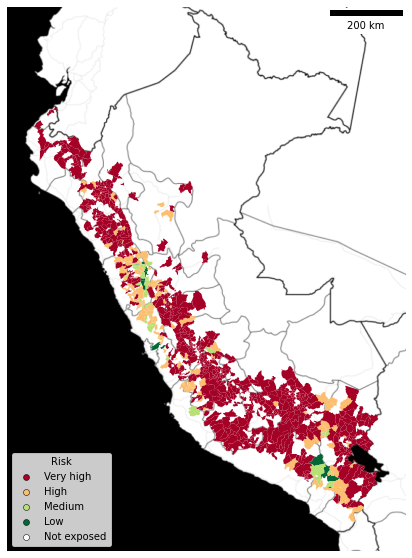

Shock: landslide
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/landslide/peru_landslide_variables_table.csv
[[0.6326053047540297], [0.807538952106972], [0.8438885631227496], [0.8610628789466246], [0.8693334801247979]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


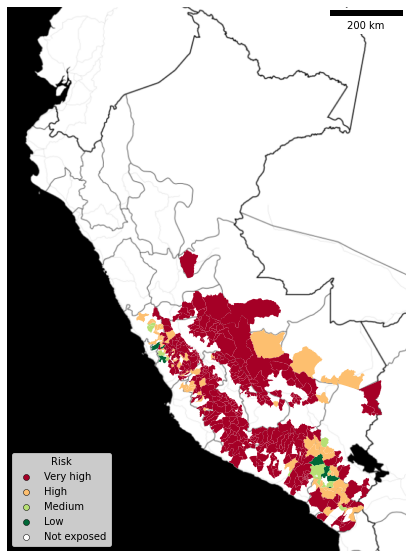

Shock: frost
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/frost/peru_frost_variables_table.csv
[[0.6438145358744246], [0.8105229064511837], [0.8441519187763816], [0.8615311251048433], [0.8693039882156376]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


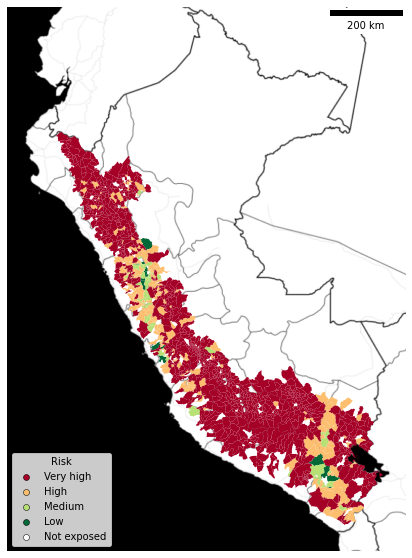

Shock: extreme cold
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/extreme cold/peru_extreme cold_variables_table.csv
[[0.30475914118667613], [0.7524456347924351], [0.8292723542006704], [0.8574825947037904], [0.8692631029785983]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


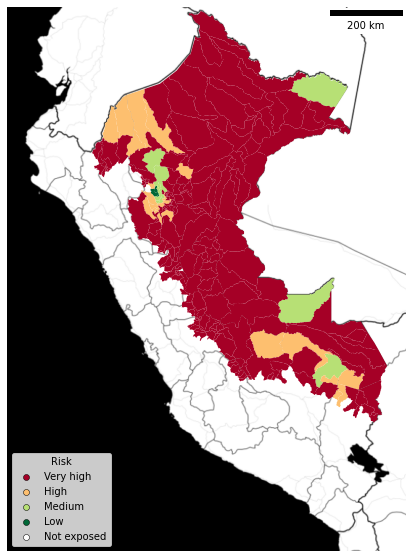

Shock: snow
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/snow/peru_snow_variables_table.csv
[[0.7969353709521865], [0.832955281446897], [0.8542144484367362], [0.8641202970758974], [0.8697457356546358]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


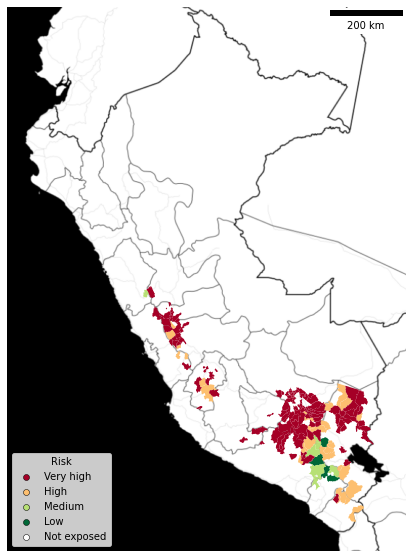

Shock: floods
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/floods/peru_floods_variables_table.csv
[[0.647524357214506], [0.775642198111256], [0.8150560273780201], [0.8378949266555685], [0.8590795620271494], [0.8703827764810769]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


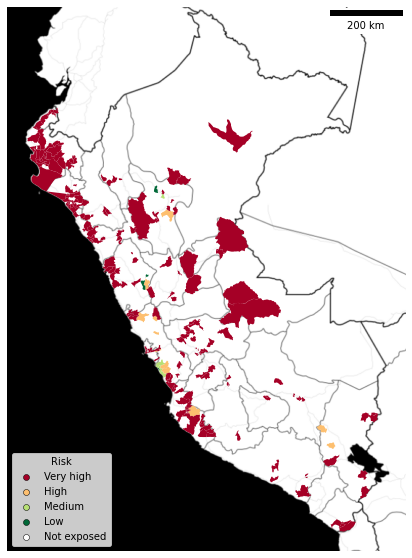

Shock: mass movements
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/mass movements/peru_mass movements_variables_table.csv
[[0.6475237575461144], [0.7924454718642394], [0.8432927071243349], [0.8583809344216728], [0.866634949931138], [0.8703649574935564]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


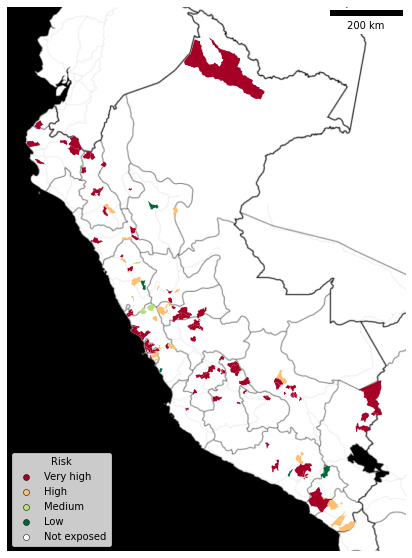

Shock: droughts
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/droughts/peru_droughts_variables_table.csv
[[0.6438141641638289], [0.810040182759215], [0.8425221224151814], [0.8586917797500783], [0.8657017873104154], [0.8699067064254412]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


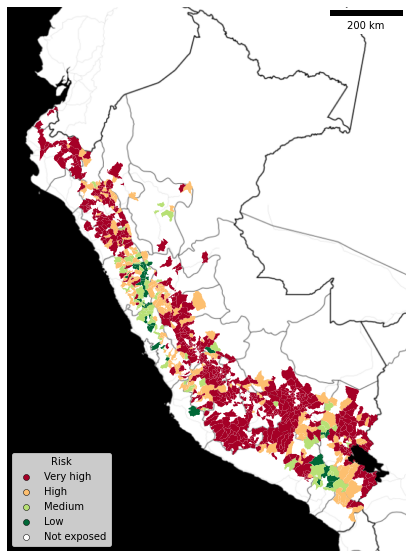

Shock: landslide
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/landslide/peru_landslide_variables_table.csv
[[0.6326053047540297], [0.807538952106972], [0.842343376458493], [0.8583870155650023], [0.8657003531310911], [0.869950254026021]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


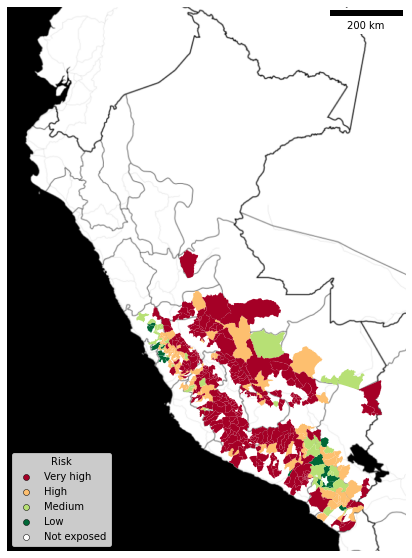

Shock: frost
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/frost/peru_frost_variables_table.csv
[[0.6438145358744246], [0.8105229064511837], [0.8434532333321836], [0.8585440374841523], [0.8653024324005975], [0.8698214720926523]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


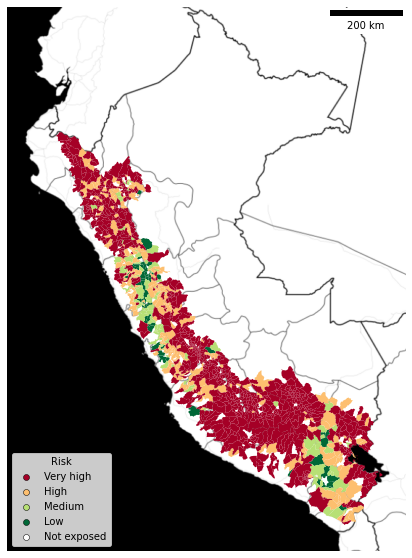

Shock: extreme cold
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/extreme cold/peru_extreme cold_variables_table.csv
[[0.30475914118667613], [0.7524456347924351], [0.8059469735323166], [0.8335133325040075], [0.8574825947037904], [0.8692631029785983]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


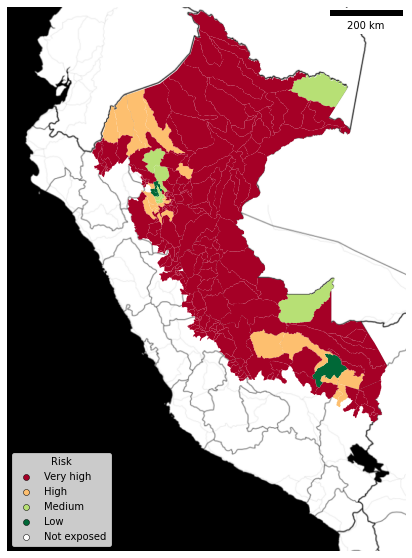

Shock: snow
Reading: /Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/snow/peru_snow_variables_table.csv
[[0.7969353709521865], [0.832955281446897], [0.8528218092238916], [0.8614344698142522], [0.8660982950364317], [0.8699061801125346]]


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


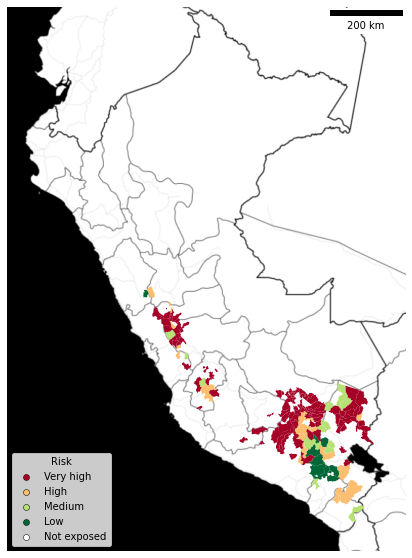

Administration 1 Code Administration 2 Code Administration 3 Code   
0                    02                  0205                020504  \
1                    02                  0205                020508   
2                    03                  0305                030501   
3                    03                  0305                030504   
4                    03                  0305                030505   

  Administration 1 Administration 2 Administration 3  Percentage   
0           ANCASH        BOLOGNESI            AQUIA      0.2190  \
1           ANCASH        BOLOGNESI        HUALLANCA      0.0841   
2         APURIMAC       COTABAMBAS       TAMBOBAMBA      0.0085   
3         APURIMAC       COTABAMBAS          HAQUIRA      1.0000   
4         APURIMAC       COTABAMBAS             MARA      1.0000   

   Percentage Category I  Percentage Category II  Percentage Category III   
0                 0.3333                     0.0                      0.0  \
1                 0.5000                     0.0                      0.0   
2                 0.8182                     0.0                      0.0   
3                 0.7500                     0.0                      0.0   
4                 0.7143                     0.0                      0.0   

   ...  Per Ess 100hab  PHC Dist Km  Hospital Dist Km   Rr Resp     Rr Cv   
0  ...       27.272728   464.256588        469.733443  2.540437  6.314773  \
1  ...        1.817851   952.273329        956.181552  2.544231  6.287048   
2  ...       30.946066  9899.790240       9907.431983  2.574816  6.017835   
3  ...       27.274498  9496.596034       9558.416941  2.553676  6.210927   
4  ...       43.630016  9296.088565       9307.723037  2.553676  6.210927   

      Rr Dm    Cosine Similarity  Cosine Distance  Risk To Measure  Risk Tag  
0  3.548537     0.15297736344517         0.847023         0.847023         1  
1  3.540899  0.13261251089241002         0.867387         0.867387         3  
2  3.431011  0.13011269014347968         0.869887         0.869887         4  
3  3.512306   0.1304629715286083         0.869537         0.869537         4  
4  3.512306   0.1310352300727391         0.868965         0.868965         4  

[5 rows x 32 columns]

In [122]:
for K_NUM in [4, 5, 6]:
    for shock in shock_list:
        print("Shock:", shock)
        data_vector = None

        path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_variables_table.csv"
        print("Reading:", path)
        data_vector = pd.read_csv(path, dtype={ADMINISTRATION_STUDY: str})

        df = data_vector.copy()
        better_values = ["ideal_values"] + ideal_values

        better_values = {
            col_name: pd.Series(val) for col_name, val in zip(df.columns, better_values)
        }
        better_values = pd.DataFrame(better_values)

        data_resumen = pd.concat([better_values, df], ignore_index=True)
        data_resumen = cosine_similarity_df(data_resumen)
        data_resumen = data_resumen.iloc[1:, :]

        for elem in delete_columns_for[shock]:
            del data_resumen[elem]

        data_resumen["Risk To Measure"] = data_resumen["Risk To Measure"].astype(float)
        X = data_resumen[["Risk To Measure"]]
        kmeans = KMeans(n_clusters=K_NUM, random_state=42).fit(X)

        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_.tolist()

        centroids_order = sorted(centroids, key=lambda x: x)
        index_orders = [centroids.index(x) for x in centroids_order]
        labels_order = [index_orders.index(i) + 1 for i in labels]

        print(centroids_order)

        data_resumen["Risk Tag"] = labels_order

        data_resumen = pd.merge(
            fsupport.rename_columns(
                administrative_areas_dict[ADMINISTRATION_STUDY[:16]]
            ),
            # administrative_areas_dict[ADMINISTRATION_STUDY[:16]][[ADMINISTRATION_STUDY, ADMINISTRATION_STUDY[:16], "geometry"]],
            data_resumen,
            how="right",
            left_on=[
                ADMINISTRATION_STUDY,
            ],
            right_on=[
                ADMINISTRATION_STUDY,
            ],
            sort=True,
            suffixes=("_x", "_y"),
        )  # .sort_values(['CodigoPrestador'], ascending=False)

        data_resumen["Risk Tag"] = data_resumen["Risk Tag"].astype(int)

        if K_NUM == 6:
            dict_re_order = {1: 1, 2: 1, 3: 1, 4: 2, 5: 3, 6: 4}  # k=6
            data_resumen["Risk Tag"] = (
                data_resumen["Risk Tag"].replace(dict_re_order).astype(int)
            )

        if K_NUM == 5:
            dict_re_order = {1: 1, 2: 1, 3: 2, 4: 3, 5: 4}  # k=5
            data_resumen["Risk Tag"] = (
                data_resumen["Risk Tag"].replace(dict_re_order).astype(int)
            )

        # FIGURES --------------------------------

        data_temp = gpd.GeoDataFrame(data_resumen, geometry="geometry")
        col = "Risk Tag"
        data_temp = data_temp.sort_values(by=[col], ascending=[True])

        fig, ax = plt.subplots(figsize=(14, 10))
        ax.set_xlim([-82.0, -68.0])  # type: ignore # Límites en la coordenada X
        ax.set_ylim([-19.0, 0.1])  # type: ignore # Límites en la coordenada Y
        ax.axis("off")
        cmap_color = "RdYlGn_r"
        # cmap_color = 'RdYlGn'

        norm = fsupport.get_color_scale(data_temp, col)

        plot = data_temp.plot(
            ax=ax,
            column=col,
            cmap=cmap_color,
        )  # legend = True)
        ctx.add_basemap(
            plot,
            crs="epsg:4326",
            source=ctx.providers.Stamen.TonerBackground,
            attribution="",
        )

        A = [
            -70.1 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude of interest here
        B = [
            -70.8 * np.pi / 180.0,
            -2.5 * np.pi / 180.0,
        ]  # set latitude & longitude (longitude in A +1) of interest here
        dx = (6371000) * haversine_distances([A, B])[0, 1]
        ax.add_artist(ScaleBar(dx=dx, units="m"))

        # Obtener los valores únicos de vulnerabilidad
        vulnerability_values = data_temp[col].unique()

        # Colores para la leyenda
        cmap = mpl.colormaps.get_cmap("RdYlGn_r")
        points = np.linspace(0, 1, len(vulnerability_values))
        legend_colors = mcolors.ListedColormap(cmap(points))

        # Añadir los puntos y las etiquetas en la leyenda
        labels_dict = {4: "Very high", 3: "High", 2: "Medium", 1: "Low"}

        if not fsupport.qty_departments_complete(
            COUNTRY_NAME, len(data_temp), administrative_level=3
        ):
            ax.scatter(
                [],
                [],
                color="white",
                label="Not exposed",
                edgecolors="black",
                linewidths=0.5,
            )

        for i, value in enumerate(vulnerability_values):
            ax.scatter(
                [],
                [],
                color=legend_colors(i),
                label=labels_dict[value],
                edgecolors="black",
                linewidths=0.5,
            )
            # ax.scatter([], [], color=legend_colors(i), label=value, edgecolors='black', linewidths=0.5)

        # Mostrar la leyenda
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]

        # Mostrar la leyenda invertida
        ax.legend(handles, labels, title="Risk", loc="lower left")
        # ax.legend(title='Risk', loc='lower right')

        path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_kmeans{K_NUM}_over_distance_figure.png"
        plt.savefig(path, format="png", dpi=150, bbox_inches="tight")

        plt.show()

        del data_resumen["geometry"]
        path = f"{directory}/{shock}/{COUNTRY_NAME}_{shock}_ranking_kmeans{K_NUM}_over_distance_labeled_table.csv"
        data_resumen.to_csv(path, index=False)
data_resumen.head()

In [123]:
ADMINISTRATION_STUDY[:16]

'Administration 3'

# End


## generating risk list de top 3 bottom 3


In [124]:
shock_list = [
    "floods",
    "mass movements",
    "droughts",
    "landslide",
    "frost",
    "extreme cold",
    "snow",
]

In [125]:
data_sample = pd.DataFrame()
for s in shock_list:
    path = f"{PATH_DATA}/data/peru/{RESULT_DIR}/{s}/peru_{s}_ranking_quartils_over_distance_labeled_table.csv"
    data_temp = pd.read_csv(path)
    data_temp = data_temp[
        [
            "Administration 1",
            "Administration 2",
            "Administration 3",
            "Risk To Measure",
            "Risk Tag",
        ]
    ]
    for i in set(data_temp["Risk Tag"]):
        data_temp_sub = data_temp[data_temp["Risk Tag"] == i]
        top_3 = data_temp_sub.head(3)
        dummy_row = pd.DataFrame(
            {
                "Administration 1": ["..."],
                "Administration 2": ["..."],
                "Administration 3": ["..."],
                "Risk To Measure": [None],
                "Risk Tag": [i],
            }
        )
        bottom_3 = data_temp_sub.tail(3)
        top_3 = pd.concat([top_3, dummy_row])
        top_3 = pd.concat([top_3, bottom_3])
        top_3["shock"] = s
        data_sample = pd.concat([data_sample, top_3])

data_sample = data_sample.reset_index(drop=True)
data_sample

Administration 1 Administration 2    Administration 3  Risk To Measure   
0             ANCASH            HUARI   CHAVIN DE HUANTAR         0.649972  \
1         SAN MARTIN            LAMAS  ALONSO DE ALVARADO         0.765142   
2             ANCASH            HUARI          RAHUAPAMPA         0.788599   
3                ...              ...                 ...              NaN   
4              JUNIN          CHUPACA   SAN JUAN DE ISCOS         0.869437   
..               ...              ...                 ...              ...   
191            PASCO            PASCO               VICCO         0.870271   
192              ...              ...                 ...              NaN   
193            CUSCO            CUSCO               CUSCO         0.871129   
194            CUSCO            CUSCO            SANTIAGO         0.871156   
195            CUSCO            CUSCO       SAN SEBASTIAN         0.871303   

     Risk Tag   shock  
0           1  floods  
1           1  floods  
2           1  floods  
3           1  floods  
4           1  floods  
..        ...     ...  
191         4    snow  
192         4    snow  
193         4    snow  
194         4    snow  
195         4    snow  

[196 rows x 6 columns]

In [126]:
path = f"{PATH_DATA}/data/peru/{RESULT_DIR}/peru_abstract_ranking_quartils_over_distance_labeled_table.csv"
data_sample.to_csv(path, index=False)

In [172]:

data_sample = pd.DataFrame()
for s in shock_list:
    path = f"{PATH_DATA}/data/peru/{RESULT_DIR}/{s}/peru_{s}_ranking_kmeans4_over_distance_labeled_table.csv"
    data_temp = pd.read_csv(path)
    data_temp = data_temp.sort_values(by=['Risk To Measure'], ascending=True).reset_index(drop=True)
    data_temp['index'] = list(range(1,len(data_temp)+1))
    data_temp['index'] = data_temp['index'].astype(str)
    data_temp = data_temp[
        [
            "index",
            "Administration 1",
            "Administration 2",
            "Administration 3",
            "Risk To Measure",
            "Risk Tag",
        ]
    ]
    for i in set(data_temp["Risk Tag"]):
        data_temp_sub = data_temp[data_temp["Risk Tag"] == i]
        if len(data_temp_sub) <= 6:
            data_temp_sub["shock"] = s
            data_sample = pd.concat([data_sample, data_temp_sub])
        else:
            top_3 = data_temp_sub.head(3)
            dummy_row = pd.DataFrame(
                {
                    "index": ["..."],
                    "Administration 1": ["..."],
                    "Administration 2": ["..."],
                    "Administration 3": ["..."],
                    "Risk To Measure": [None],
                    "Risk Tag": [i],
                }
            )
            bottom_3 = data_temp_sub.tail(3)
            top_3 = pd.concat([top_3, dummy_row])
            top_3 = pd.concat([top_3, bottom_3])
            top_3["shock"] = s
            data_sample = pd.concat([data_sample, top_3])

data_sample = data_sample.reset_index(drop=True)
# data_sample['index'] = data_sample['index'].astype(int)
# data_sample_columns = list(data_sample.columns)
# data_sample['index'] = data_sample.groupby('shock').cumcount() + 1
# data_sample = data_sample[['index'] + data_sample_columns]

path = f"{PATH_DATA}/data/peru/{RESULT_DIR}/peru_abstract_ranking_kmeans4_over_distance_labeled_table.csv"
data_sample.to_csv(path, index=False)

data_sample

/var/folders/yh/mnw4_865319d05f6fkrpt6280000gn/T/ipykernel_22701/4155447482.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_sub["shock"] = s
/var/folders/yh/mnw4_865319d05f6fkrpt6280000gn/T/ipykernel_22701/4155447482.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_sub["shock"] = s
/var/folders/yh/mnw4_865319d05f6fkrpt6280000gn/T/ipykernel_22701/4155447482.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

index Administration 1 Administration 2    Administration 3   
0       1           ANCASH            HUARI   CHAVIN DE HUANTAR  \
1       2       SAN MARTIN            LAMAS  ALONSO DE ALVARADO   
2       3           ANCASH            HUARI          RAHUAPAMPA   
3       4             LIMA           CAÑETE         SAN ANTONIO   
4       5           ANCASH            HUARI               MASIN   
..    ...              ...              ...                 ...   
136    37     HUANCAVELICA         HUAYTARA          PILPICHACA   
137   ...              ...              ...                 ...   
138   166            CUSCO            CUSCO               CUSCO   
139   167            CUSCO            CUSCO            SANTIAGO   
140   168            CUSCO            CUSCO       SAN SEBASTIAN   

     Risk To Measure  Risk Tag   shock  
0           0.647524         1  floods  
1           0.763179         2  floods  
2           0.788106         2  floods  
3           0.814737         3  floods  
4           0.815375         3  floods  
..               ...       ...     ...  
136         0.865889         4    snow  
137              NaN         4    snow  
138         0.871212         4    snow  
139         0.871239         4    snow  
140         0.871386         4    snow  

[141 rows x 7 columns]

In [173]:
data_sample[data_sample['shock']=='floods']

index Administration 1 Administration 2    Administration 3   
0      1           ANCASH            HUARI   CHAVIN DE HUANTAR  \
1      2       SAN MARTIN            LAMAS  ALONSO DE ALVARADO   
2      3           ANCASH            HUARI          RAHUAPAMPA   
3      4             LIMA           CAÑETE         SAN ANTONIO   
4      5           ANCASH            HUARI               MASIN   
5      6             LIMA           CAÑETE                MALA   
6    ...              ...              ...                 ...   
7     10             LIMA           CAÑETE              CHILCA   
8     11              ICA              ICA   YAUCA DEL ROSARIO   
9     12           ANCASH            HUARI          SAN MARCOS   
10    13             LIMA           CAÑETE             CALANGO   
11    14             LIMA           HUARAL      ATAVILLOS BAJO   
12    15             LIMA       HUAROCHIRI       RICARDO PALMA   
13   ...              ...              ...                 ...   
14   230           TUMBES           TUMBES              TUMBES   
15   231      LA LIBERTAD           CHEPEN              CHEPEN   
16   232       LAMBAYEQUE         CHICLAYO               TUMAN   

    Risk To Measure  Risk Tag   shock  
0          0.647524         1  floods  
1          0.763179         2  floods  
2          0.788106         2  floods  
3          0.814737         3  floods  
4          0.815375         3  floods  
5          0.834719         3  floods  
6               NaN         3  floods  
7          0.842296         3  floods  
8          0.850229         3  floods  
9          0.851426         3  floods  
10         0.856531         4  floods  
11         0.856643         4  floods  
12         0.857228         4  floods  
13              NaN         4  floods  
14         0.871398         4  floods  
15         0.871462         4  floods  
16         0.871495         4  floods

In [164]:
data_sample['index'] = list(range(len(data_temp)))

data_sample

index
0        0
1        1
2        2
3        3
4        4
..     ...
227    227
228    228
229    229
230    230
231    231

[232 rows x 1 columns]